# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [38]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


#dir(random)  # Reminding ourselves what we can do here

In [39]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [40]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []
random.seed(42)
for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [41]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [42]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [66]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5, labels=False)  # 5 equal-sized bins
#print(time_bins)
#time_bins = [(5.196, 124.547] < (124.547, 243.304] < (243.304, 362.062] < (362.062, 480.819] < (480.819, 599.577]]
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,0,1,2,3,4
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [67]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,0,1,2,3,4
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [68]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


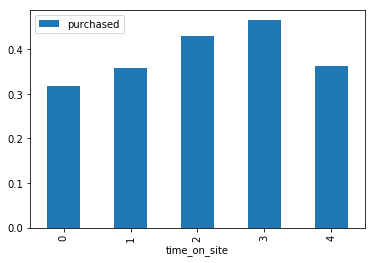

In [79]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

#pd.crosstab(user_data['mobile'], user_data['purchased'], time_bins, aggfunc=','.join) #, rownames=['device'], colnames=['purchased', 'time on site'] normalize='index')

pd.pivot_table(user_data,values='purchased', index=time_bins).plot.bar()

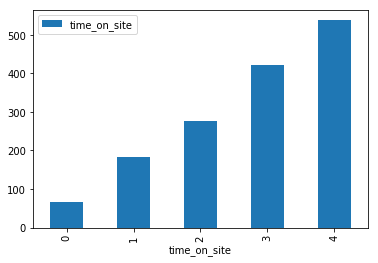

In [80]:
pd.pivot_table(user_data,values='time_on_site', index=time_bins).plot.bar()

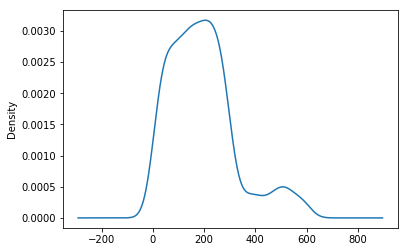

In [78]:
user_data['time_on_site'].plot.density()
#pd.pivot_table(user_data,values='purchased', index=bin).plot.bar()

In [82]:
ct= pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
print(ct)

purchased        False               True           
mobile           False     True      False     True 
time_on_site                                        
0             0.210227  0.413043  0.054054  0.351724
1             0.244318  0.423913  0.148649  0.420690
2             0.204545  0.163043  0.243243  0.227586
3             0.130682  0.000000  0.270270  0.000000
4             0.210227  0.000000  0.283784  0.000000


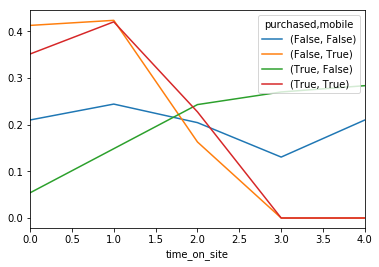

In [83]:
ct.plot()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [84]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself
!ls

LS_DS_114_Making_Data_backed_Assertions.ipynb  persons.csv  Untitled.ipynb


In [115]:
people = pd.read_csv('persons.csv')
print(people.describe())

        Unnamed: 0          age       weight  exercise_time
count  1200.000000  1200.000000  1200.000000    1200.000000
mean    599.500000    48.396667   153.540833     134.910833
std     346.554469    18.166802    35.132182      85.548895
min       0.000000    18.000000   100.000000       0.000000
25%     299.750000    33.000000   125.000000      65.000000
50%     599.500000    48.000000   149.000000     122.000000
75%     899.250000    64.000000   180.250000     206.000000
max    1199.000000    80.000000   246.000000     300.000000


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


1) The variables in this data, are age, weight, and exercise_time.
(Stating my assumptions upfront, exercise_time is the amount of time each day they spend exercising)
2) The relationships between the variables are, the person's age, their weight, and the amount of time they spend exercising(see note in question 1).
3) This data only presents spurious data, There are too many ourside variables to consider.
(The data even backs this up to a point, the weights plotted in a bar graph accross the board are all close to the same, they do not vary enough to prove anything. The exercise_time plotted in a bar chart according to age shows a tendancy for older people to exercise less, but there are too many outside factors that could come into play that would effect this data.)


In [120]:
print(people.head())

   Unnamed: 0  age  weight  exercise_time
0           0   44     118            192
1           1   41     161             35
2           2   46     128            220
3           3   39     216             57
4           4   28     116            182


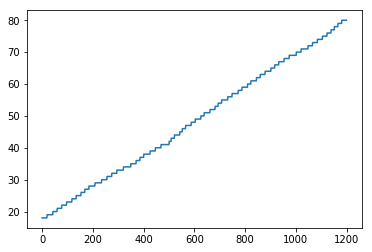

In [102]:
# plt.plot(people['age'], people['weight'])

age_sorted = people.sort_values('age', ascending=True)

#plt.plot(range(0,1200), age_sorted['weight'])

#plt.plot(range(0,1200), age_sorted['age'])

#print(age_sorted['age'])

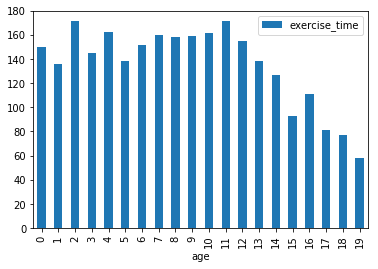

In [128]:
time_bins = pd.cut(age_sorted['age'], 20, labels=False)  # 5 equal-sized bins
#print(time_bins)
#time_bins = [(5.196, 124.547] < (124.547, 243.304] < (243.304, 362.062] < (362.062, 480.819] < (480.819, 599.577]]
#pd.crosstab(people['weight'], time_bins)

pd.pivot_table(age_sorted,values='exercise_time', index=time_bins).plot.bar()

#plt.bar(age_sorted['age'], age_sorted['exercise_time'], index=time_bins)

This proves nothing, as it is a corrolation, too many outside variables could have the same effect. 

The first thing that I see is this graph, I have the Data Frame sorted by age, and plotting the exercise time accross the ages, I can see that on the average, Older people spend less time exercising.

I have cut the bins down to 20, and you can plainly see this trend, taking the number of bins down much more than 20 tend to obscure the trend, and adding more bins make things a little redundant.

This is only a corrolation, and it tells us nothing, there could be any number of outside factors that affect this data.


In [116]:
weight_sorted = people.sort_values('weight', ascending=True)
exercise_sorted = people.sort_values('exercise_time', ascending=True)


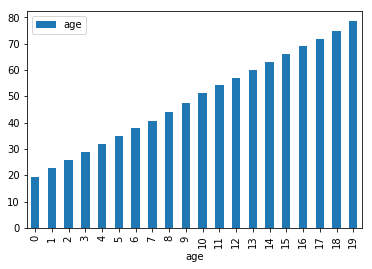

In [135]:
pd.pivot_table(exercise_sorted,values='age', index=time_bins).plot.bar()

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)